# Check the Re-chunking of EOR sims

In [19]:
from pathlib import Path
from pyuvdata import UVData, __version__
from pyuvdata.uvdata import FastUVH5Meta
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import yaml
import healpy as hp
import h5py

In [3]:
with open("../h4c_freqs.yaml", 'r') as fl:
    freq_info = yaml.safe_load(fl)

In [4]:
freqs = np.arange(freq_info['start'], freq_info['end'], freq_info['delta'])

In [5]:
chnkpth = Path("../outputs/eor/chunked")
rawpth = Path("../outputs/eor/nt17280/")

In [6]:
chnkfiles = sorted(chnkpth.glob("*.uvh5"))

In [7]:
len(chnkfiles)

96

In [8]:
rawfiles0 = sorted(rawpth.glob("*_chunk0.uvh5"))

In [9]:
meta = FastUVH5Meta(rawfiles0[0])

In [10]:
zerofrqs = [FastUVH5Meta(fl) for fl in sorted(rawpth.glob("*fch0000*.uvh5"))]
raw_chunk_lst0 = [m.lsts[0] for m in zerofrqs]

In [11]:
lsts_all = [m.lsts for m in zerofrqs]

In [12]:
raw_chunk_lst0

[2.262659908325304e-07, 2.0943950788586005, 4.1887899452921795]

In [13]:
chans = np.nonzero((freqs >= 174e6) & (freqs < 194e6))[0]
chnslice = slice(chans[0], chans[-1]+1)

In [14]:
chnkmeta = FastUVH5Meta(chnkfiles[0])

## Check each file is exactly the same as chunked files

In [15]:
timechunk = 60

In [16]:
logfile = 'check_rechunk_eor.log'

In [26]:
np.nanmax(np.abs((thisd[mask] - rechunk_data[idx==chnk][:, :, i]).imag/thisd[mask].imag))

/tmp/ipykernel_51038/671037784.py:1: RuntimeWarning: invalid value encountered in divide
  np.nanmax(np.abs((thisd[mask] - rechunk_data[idx==chnk][:, :, i]).imag/thisd[mask].imag))


5.933788615914066e-08

In [ ]:
done = []
worst_comp = 0
worst_thing = None

for outerchunk, chunkfl in enumerate(chnkfiles[31:], start=32):
    print(f"DOING CHUNKED FILE: {outerchunk+1}/{len(chnkfiles)}: {chunkfl.name}")
    
    chnkmeta = FastUVH5Meta(chunkfl)
    ntimes = chnkmeta.Ntimes
    
    ntime_chunks = ntimes // timechunk
    
    for tchunk in range(ntime_chunks):
        print(f"  DOING SUBCHUNK {tchunk+1}/{ntime_chunks}")
        
        this = slice(tchunk*timechunk, (tchunk+1)*timechunk)
        idx = np.zeros(timechunk, dtype=int)
        
        idx[chnkmeta.lsts[this] >= raw_chunk_lst0[1]] = 1
        idx[chnkmeta.lsts[this] >= raw_chunk_lst0[2]] = 2
        req_idx = np.sort(np.unique(idx))

        with h5py.File(chunkfl, 'r') as fl:
            rechunk_data = fl['Data']['visdata'][this.start*chnkmeta.Nbls:this.stop*chnkmeta.Nbls, chnslice, :].reshape((timechunk, chnkmeta.Nbls, len(chans), 4))

        for chnk in req_idx:        
            print(f"    > chunk {chnk}")
            print("       ", end='')
            
            rawfls = sorted(rawpth.glob(f"*_chunk{chnk}.uvh5"))

            for i, pth in enumerate(rawfls[chans[0]:chans[-1]]):
                print(".",end='', flush=True)
                
                with h5py.File(pth, 'r') as fl:
                    thisd = fl['Data']['visdata'][()].reshape((meta.Ntimes, meta.Nbls, 4))

                thislst = lsts_all[chnk]
                mask = (thislst >= chnkmeta.lsts[this][0]) & (thislst <= chnkmeta.lsts[this][-1])
                badness = np.nanmax(np.abs(thisd[mask] - rechunk_data[idx==chnk][:, :, i])/np.abs(thisd[mask]))
                if badness > worst_comp:
                    worst_comp = badness
                    worst_thing = (outerchunk, tchunk, chnk, i)
                    print("New Worst: ", worst_thing, worst_comp)
                    
                if badness > 1e-7:
                    raise AssertionError(f'on chnkfl={chnkfl}, chnk={chnk}, chan={chans[i]}')
                
            done.append((outerchunk, tchunk, chnk))
            with open(logfile, 'a') as fl:
                fl.write('\n'+str(done))

DOING CHUNKED FILE: 33/96: zen.LST.2.0289452.eor.uvh5
  DOING SUBCHUNK 1/3
    > chunk 0
       .New Worst:  (32, 0, 0, 0) 5.916933348183008e-08
.New Worst:  (32, 0, 0, 1) 5.941543708087131e-08
........New Worst:  (32, 0, 0, 9) 5.947219525531974e-08
................................................................New Worst:  (32, 0, 0, 73) 5.949792115389131e-08
.New Worst:  (32, 0, 0, 74) 5.94983151923804e-08
.......................................New Worst:  (32, 0, 0, 113) 5.952901942360582e-08
................................................  DOING SUBCHUNK 2/3
    > chunk 0
       .......................................................................................New Worst:  (32, 1, 0, 86) 5.954961469745227e-08
...........................................................................  DOING SUBCHUNK 3/3
    > chunk 0
       ...................................................New Worst:  (32, 2, 0, 50) 5.955692837875206e-08
........................................................

## Check Delay Spectrum in each file

In [36]:
nt = chnkmeta.Ntimes
nbl = chnkmeta.Nbls

In [37]:
chnkmeta.pols

['xx', 'xy', 'yx', 'yy']

In [38]:
chunksize=60

In [66]:
with h5py.File(chnkfiles[0], 'r') as fl:
    vis = fl['Data']['visdata'][:chunksize*chnkmeta.Nbls, chnslice, :]

vis = vis[..., [0, 3]].reshape((chunksize, nbl, len(chans), 2)).transpose((0,1,3,2))  # now (nt, nbl, npol, nfreq)

In [39]:
newsim_files = sorted(Path("../outputs/eor/nt17280-288chunks").glob("*_chunk000.uvh5"))

In [40]:
len(newsim_files)

162

In [41]:
newsim_meta = FastUVH5Meta(newsim_files[0])

In [67]:
# Remove the autos
vis = vis[:, 1:]

In [68]:
bh = np.blackman(len(chans))

In [69]:
dspec = np.fft.fftshift(np.abs(np.fft.fft(vis*bh, axis=-1))**2, axes=(-1,))

In [70]:
k = np.fft.fftshift(np.fft.fftfreq(len(chans)))

In [71]:
# Average over times
dspecavg = np.mean(dspec, axis=0)
dspecavgxx = dspecavg[:, 0]
dspecavgyy = dspecavg[:, 1]

In [72]:
# Get mean of high-k power
highk_meanxx = np.mean(dspecavgxx[:, -30:], axis=1)

In [73]:
uv = chnkmeta.uvw_array.reshape((nt, nbl, 3))[0, :, :2]

In [76]:
chnkmeta.antpairs[207]

(155, 4)

In [77]:
uv[mask]

array([[ 124.66588427, -130.25609509],
       [ 139.2737257 , -130.20030674],
       [ 132.01809936, -142.8749974 ],
       [ 153.88156246, -130.14451427]])

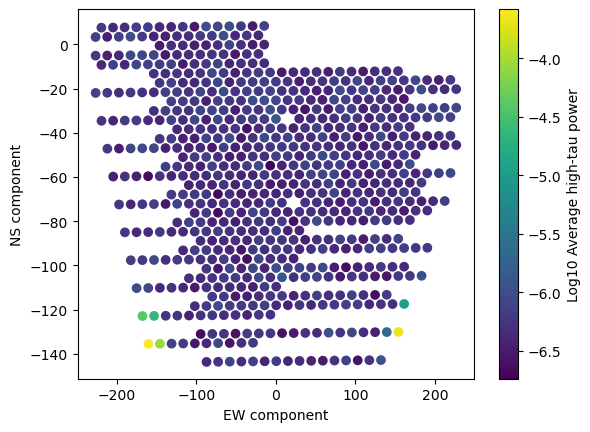

In [102]:
plt.scatter(uv[1:, 0], uv[1:, 1], c=np.log10(highk_meanxx))
plt.xlabel("EW component")
plt.ylabel("NS component")
cax = plt.colorbar()
cax.set_label("Log10 Average high-tau power")

In [79]:
mask = np.where((uv[:, 0] > 120) & (uv[:, 1] < -120))[0]
print(mask)

[207 224 226 292]


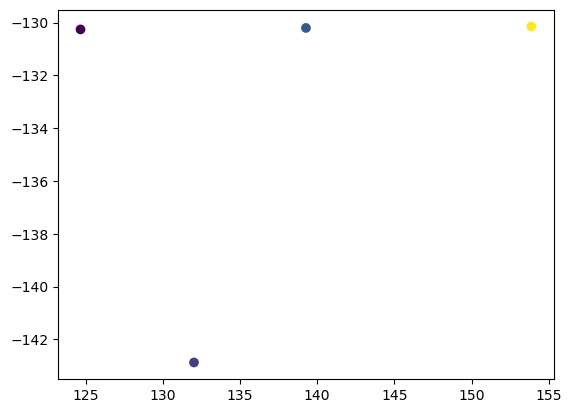

In [95]:
plt.scatter(uv[mask, 0], uv[mask, 1], c=np.log10(highk_meanxx[mask-1]))

In [87]:
decent_bl = chnkmeta.antpairs[mask[np.argmin(highk_meanxx[mask])]]
print(decent_bl)

(155, 4)


Text(0.5, 0, 'Baseline length (m)')

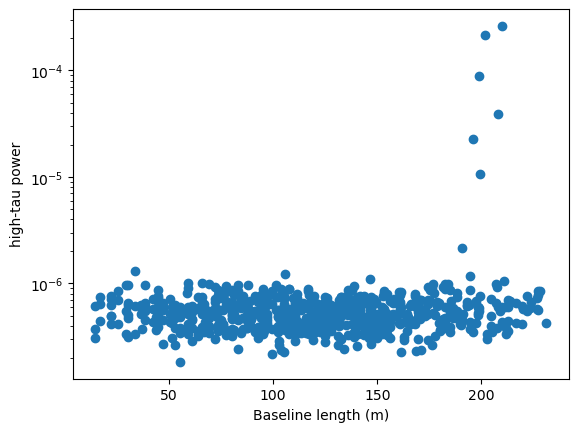

In [106]:
plt.scatter(np.sqrt(uv[1:, 0]**2 + uv[1:, 1]**2), highk_meanxx)
plt.yscale('log')
plt.ylabel("high-tau power")
plt.xlabel("Baseline length (m)")

In [92]:
highk_meanxx.shape

(706,)

In [97]:
badbls = list(np.argwhere(highk_meanxx > 5e-6)[:, 0])

In [98]:
badbls

[109, 123, 124, 251, 289, 291]

In [93]:
highk_meanxx[291]

0.00021533615340986746

In [94]:
highk_meanxx[292]

5.095695569027121e-07

In [88]:
decent_blidx = chnkmeta.antpairs[1:].index(decent_bl)

In [103]:
np.sqrt(uv[292,0]**2 + uv[292,0]**2)

217.62139262847506

In [112]:
1/(217.62/1.596)

0.007333884753239592

In [111]:
3e8 / 188e6

1.5957446808510638

In [107]:
hp.nside2resol(128)

0.007994739905831941

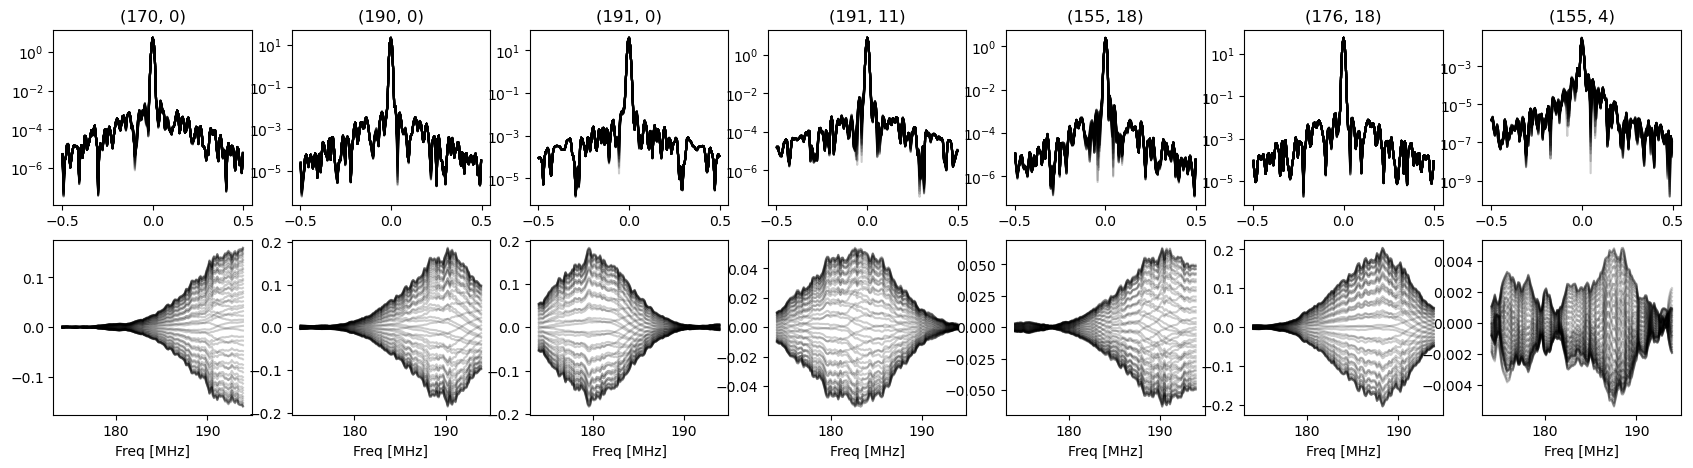

In [101]:
fig, ax = plt.subplots(2, len(badbls)+1, figsize=(3*(len(badbls)+1), 5))
for j, bl in enumerate(badbls + [decent_blidx]):
    for t in range(chunksize):
        ax[0, j].plot(k, dspec[t, bl, 0], color='k', alpha=0.2)
        ax[1, j].plot(freqs[chans]/1e6, vis[t, bl, 0].real, color='k', alpha=0.2)
        ax[0, j].set_title(f"{chnkmeta.antpairs[1:][bl]}")
        ax[1, j].set_xlabel("Freq [MHz]")
    ax[0, j].set_yscale('log')

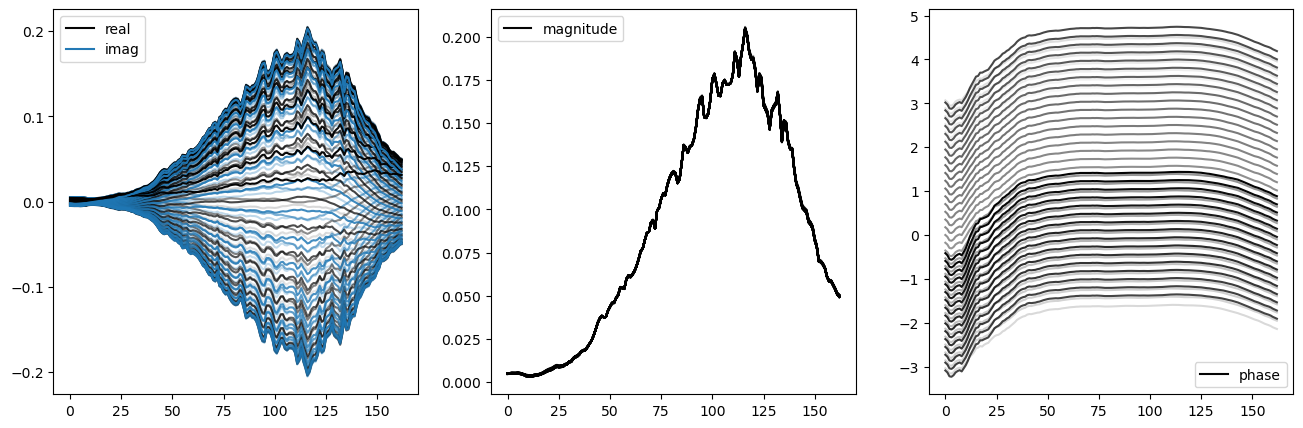

In [86]:
fig, ax = plt.subplots(1, 3, figsize=(16, 5))
for i, ddd in enumerate(dd.reshape(chunksize, -1, len(chans), 2)):
    ax[0].plot(ddd[292, :, 0].real, color='k', alpha=i*(1./chunksize), label='real' if i==59 else None)
    ax[0].plot(ddd[292, :, 0].imag, color='C0', alpha=i*(1./chunksize), label='imag' if i==59 else None)
    ax[1].plot(np.abs(ddd[292, :, 0]), color='k', alpha=i*(1./chunksize), label='magnitude' if i==59 else None)
    ax[2].plot(np.unwrap(np.angle(ddd[292, :, 0])), color='k', alpha=i*(1./chunksize), label='phase' if i==59 else None)
    
ax[0].legend()
ax[1].legend()
ax[2].legend()


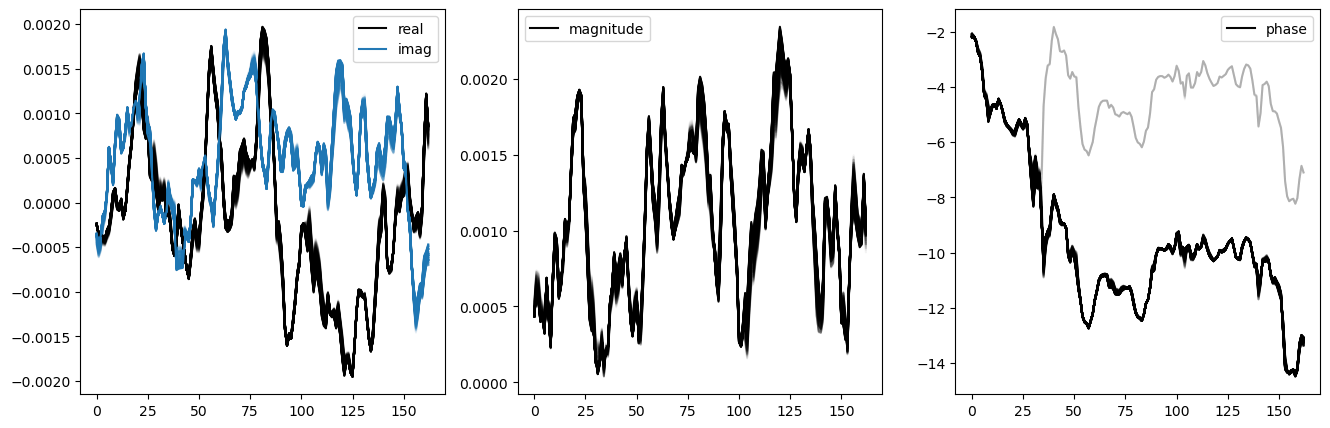

In [87]:
fig, ax = plt.subplots(1, 3, figsize=(16, 5))
for i, ddd in enumerate(dd.reshape(chunksize, -1, len(chans), 2)):
    ax[0].plot(ddd[291, :, 0].real, color='k', alpha=i*(1./chunksize), label='real' if i==59 else None)
    ax[0].plot(ddd[291, :, 0].imag, color='C0', alpha=i*(1./chunksize), label='imag' if i==59 else None)
    ax[1].plot(np.abs(ddd[291, :, 0]), color='k', alpha=i*(1./chunksize), label='magnitude' if i==59 else None)
    ax[2].plot(np.unwrap(np.angle(ddd[291, :, 0])), color='k', alpha=i*(1./chunksize), label='phase' if i==59 else None)
    
ax[0].legend()
ax[1].legend()
ax[2].legend()


/tmp/ipykernel_85208/2287059135.py:3: RuntimeWarning: divide by zero encountered in power
  plt.plot(k, np.log10(1e-6*(k/0.2)**-2), color='r')


(-10.0, 3.0)

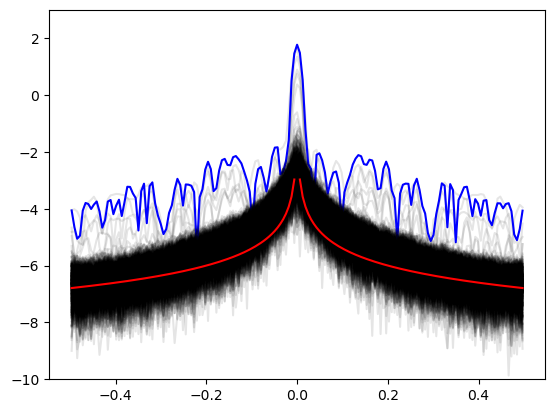

In [57]:
for i, blt in enumerate(dspecavg[1:]):
    plt.plot(k, np.fft.fftshift(np.log10(blt[:, 0])), alpha=1 if i==291 else 0.1, color='b' if i==291 else 'k')
plt.plot(k, np.log10(1e-6*(k/0.2)**-2), color='r')
plt.ylim(-10, 3)

In [37]:
vis.shape

(60, 706, 2, 163)

In [42]:
badbls

array([109, 123, 124, 251, 289, 291])

In [47]:
set(sum([chnkmeta.antpairs[x+1] for x in badbls], start=()))

{0, 11, 18, 155, 170, 176, 190, 191}

In [42]:
visnew = np.zeros((chunksize, newsim_meta.Nbls, 2, len(chans)), dtype=complex)

for i, fl in enumerate(newsim_files):
    with h5py.File(fl, 'r') as _fl:
        d = _fl['Data']['visdata'][:, :, [0,3]]
        visnew[:, :, :, i] = d.reshape((chunksize, -1, 2))

ValueError: could not broadcast input array from shape (60,25,2) into shape (60,33,2)

In [54]:
newsim_meta.antpairs.index((176,18))

15

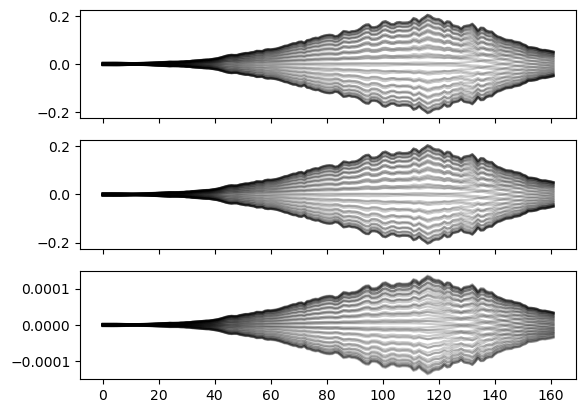

In [62]:
fig, ax = plt.subplots(3,1, sharex=True)

for t in range(chunksize):
    ax[0].plot(np.arange(len(newsim_files)), visnew[t, 15, 0, :-1].real, color='k', alpha=0.2)
    ax[1].plot(np.arange(len(newsim_files)), vis[t, 291, 0, :-1].real, color='k', alpha=0.2)
    
    ax[2].plot(np.arange(len(newsim_files)), visnew[t, 15, 0, :-1].real - vis[t, 291, 0, :-1].real, color='k', alpha=0.2)
    

In [69]:
newdspec = np.abs(np.fft.fftshift(np.fft.fft(visnew, axis=-1), axes=(-1,)))**2

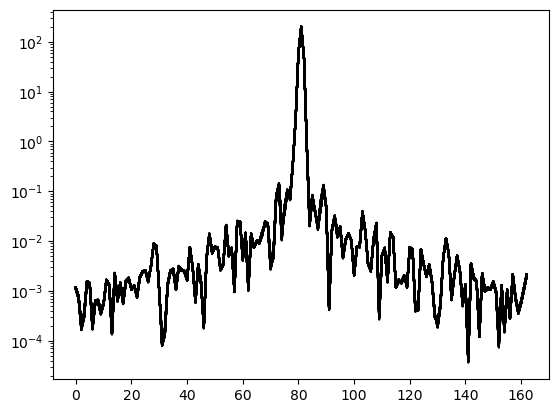

In [86]:
for t in newdspec:
    plt.plot(t[15,0], color='k')
plt.yscale('log')

In [70]:
newdspecavg = np.mean(newdspec, axis=0)

In [82]:
badblsl = [chnkmeta.antpairs[1:][x] for x in badbls]

In [83]:
badblsl

[(170, 0), (190, 0), (191, 0), (191, 11), (155, 18), (176, 18)]

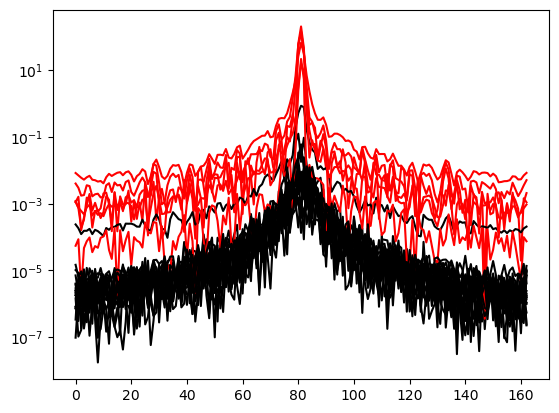

In [84]:
for i, bl in enumerate(newdspecavg):
    if i==0:
        continue
    
    plt.plot(bl[0], color='r' if newsim_meta.antpairs[i] in badblsl else 'k')
plt.yscale('log')

In [15]:
sky = np.load("../t0_f174118041.9921875_sky.npy")

In [16]:
sky.shape

(2, 2, 1, 196608)

In [23]:
sky.real.min()

-0.01824101453489371

In [24]:
skyp = np.abs(sky[0,0,0])**2 + np.abs(sky[1,0,0])**2

/tmp/ipykernel_8783/3208338018.py:1: RuntimeWarning: divide by zero encountered in log10
  hp.mollview(np.log10(skyp.real))


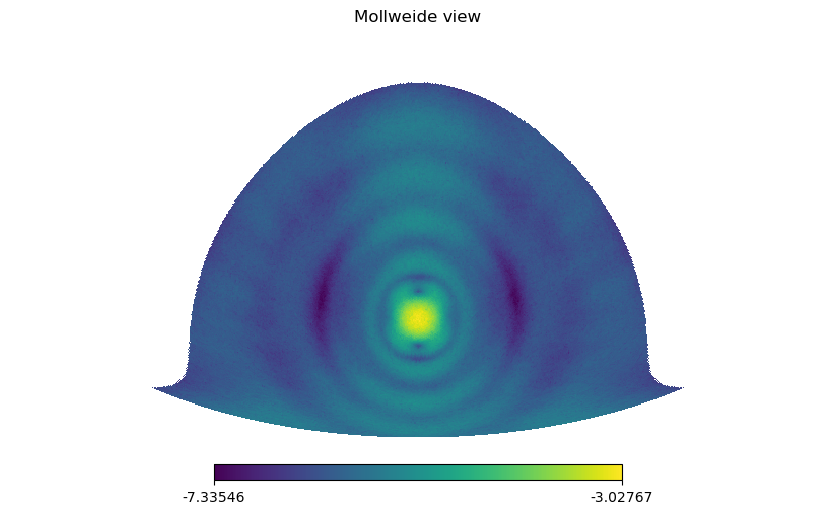

In [26]:
hp.mollview(np.log10(skyp.real))

In [46]:
v = np.load("../t0_f174118041.9921875_v.npy")

In [48]:
a = list(newsim_meta.ant_1_array[:newsim_meta.Nants_telescope]).index(176)
b = list(newsim_meta.ant_1_array[:newsim_meta.Nants_telescope]).index(18)

In [59]:
ar = list(newsim_meta.ant_1_array[:newsim_meta.Nants_telescope]).index(155)
br = list(newsim_meta.ant_1_array[:newsim_meta.Nants_telescope]).index(4)


In [53]:
zworst = v[0, a, 0] * v[0, b, 0].flatten().conj() + v[0, a, 1] * v[0, b, 1].flatten().conj()

In [60]:
zreasonable= v[0, ar, 0] * v[0, br, 0].flatten().conj() + v[0, ar, 1] * v[0, br, 1].flatten().conj()

In [63]:
zworst - zreasonable

array([ 0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
        0.00000000e+00+0.00000000e+00j, ...,
        1.82661145e-07-1.44279886e-07j,  1.15553433e-06+1.15147038e-06j,
       -2.13568175e-06+4.72061482e-07j])

In [54]:
zworst.shape

(196608,)

In [65]:
np.sum(zworst), np.sum(zreasonable)

((-0.00034327895473955724+0.005139188487493986j),
 (-0.001875893476010005-6.229016745263123e-05j))

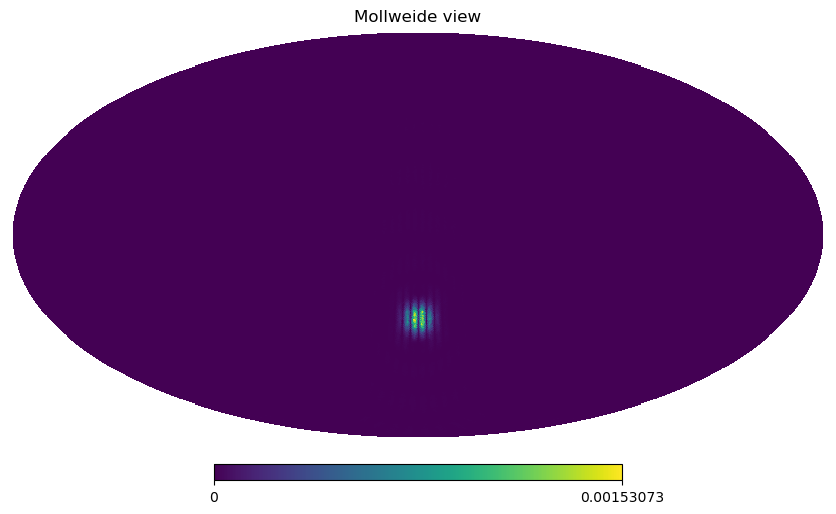

In [64]:
hp.mollview(np.abs(zworst - zreasonable))

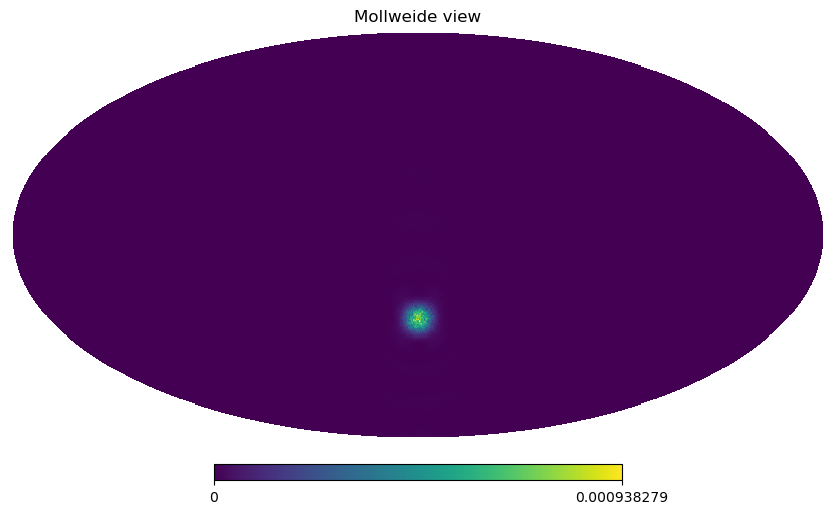

In [61]:
hp.mollview(np.abs(zreasonable))

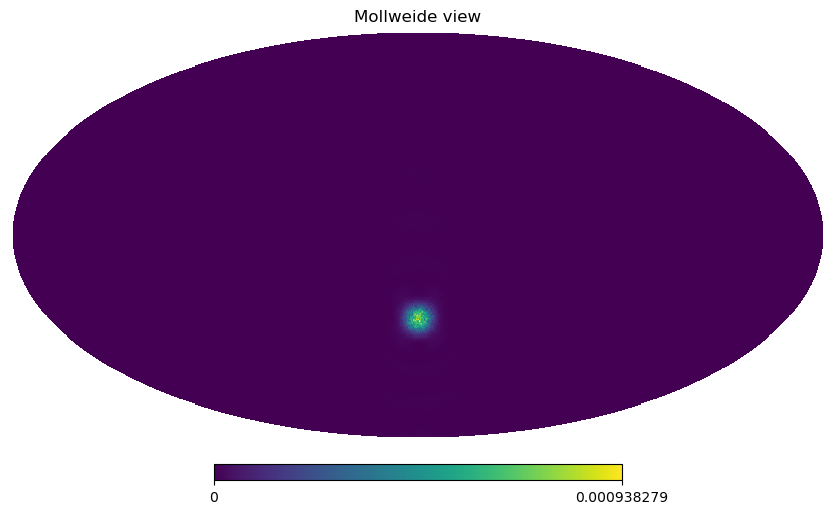

In [62]:
hp.mollview(np.abs(zworst))

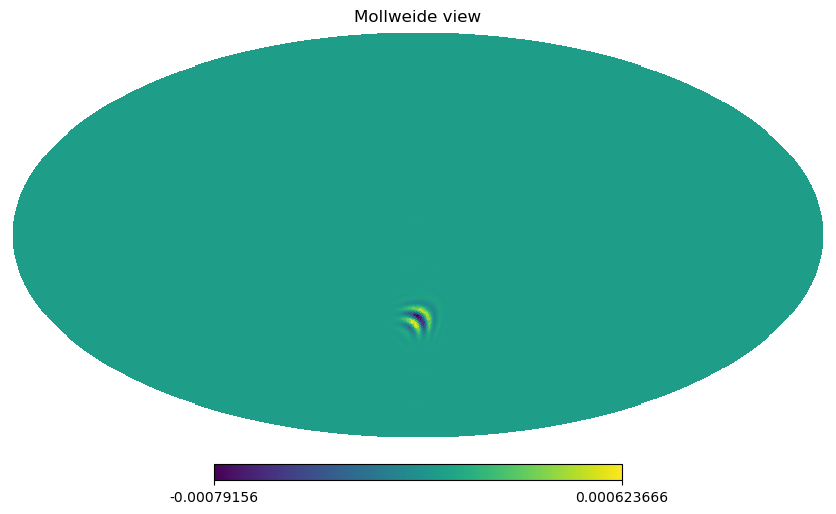

In [56]:
hp.mollview(zworst.real)

## What about the shorter baselines?

In [117]:
bllen = np.sqrt(uv[:, 0]**2 + uv[:, 1]**2)
mask = (0 < bllen) & (bllen   < 58)

In [118]:
np.sum(mask)

77

In [144]:
def fold(x):
    x[..., len(chans)//2+1:] += x[..., :len(chans)//2][..., ::-1]
    return x[..., len(chans)//2:]/2

In [154]:
def getfile(_fl):
    dspecavg = 0
    for ch in range(3):
        with h5py.File(_fl, 'r') as fl:
            # now (nt, nbl, npol, nfreq)
            vis = fl['Data']['visdata'][ch*chunksize*chnkmeta.Nbls:(ch+1)*chunksize*chnkmeta.Nbls, chnslice, [0,3]].reshape((chunksize, nbl, len(chans), 2)).transpose((0,1,3,2))
        vis  = vis[:, mask]
        dspec = np.fft.fftshift(np.abs(np.fft.fft(vis*bh))**2, axes=(-1,))
        dspecavg += fold(np.mean(dspec, axis=0))
        
    return dspecavg / 3

In [155]:
avgs = []
for fl in chnkfiles[::6]:
    avgs.append(getfile(fl))

In [147]:
k = np.fft.fftfreq(len(chans), d=freqs[1]-freqs[0])[:len(chans)//2+1]

/tmp/ipykernel_8783/264165087.py:8: RuntimeWarning: divide by zero encountered in power
  ax[0].plot(k*1e9, 1e-5*(k/1e-6)**-2.7)
/tmp/ipykernel_8783/264165087.py:9: RuntimeWarning: divide by zero encountered in power
  ax[1].plot(k*1e9, 1e-5*(k/1e-6)**-2.7)


Text(0.5, 1.0, 'yy')

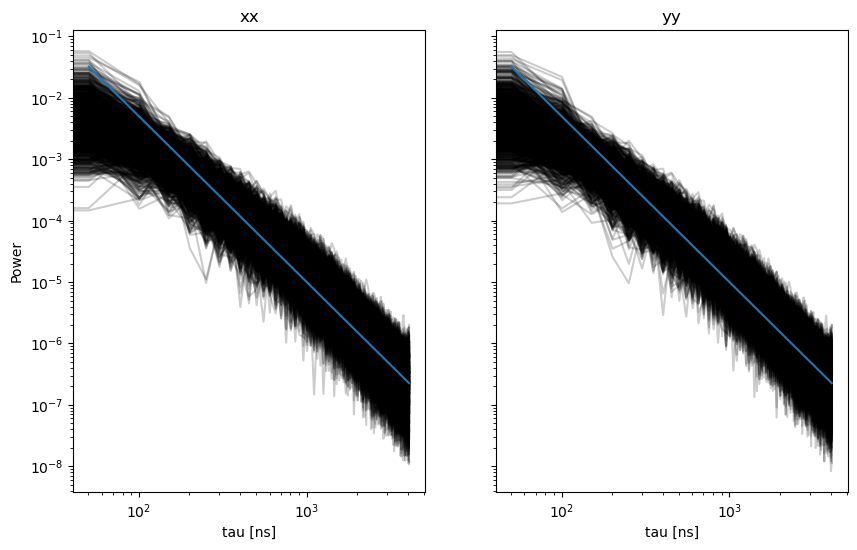

In [156]:
fig, ax = plt.subplots(1,2, sharex=True, sharey=True, figsize=(10,6))

for avg in avgs:
    for bl in avg:
        ax[0].plot(k*1e9, bl[0], alpha=0.2, color='k')
        ax[1].plot(k*1e9, bl[1], alpha=0.2, color='k')
        
ax[0].plot(k*1e9, 1e-5*(k/1e-6)**-2.7)
ax[1].plot(k*1e9, 1e-5*(k/1e-6)**-2.7)
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xlabel("tau [ns]")
ax[1].set_xlabel("tau [ns]")
ax[0].set_ylabel("Power")
ax[0].set_title("xx")
ax[1].set_title("yy")